# Use-Case: Machine Learning based Leakage Detection

Anomaly detection such as leakage detection is a classic but often non-trivial task in WDN operation. With traditional (model-based) methods reaching their limits, Machine Learning offers promising solutions.

#### Outline 
This notebook demonstrates how EPyT-Flow and EPyT-Control can be utilized to create a scenario containing several leakages that have to be detected.
Here, we use a simple Machine Learning based leakage detector that is already included in EPyT-Flow.
It consists of the following steps:
1. Create a new (realistic) scenario.
2. Add some leakages to the scenario.
3. Create a simple Machine Learning based leakage detector.
4. Evaluate the leakage detector.

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ImportWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import matplotlib.pyplot as plt
import sklearn
import epyt_flow
import pandas as pd

from sklearn.metrics import mutual_info_score
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from epyt_flow.data.networks import load_ltown
from epyt_flow.data.benchmarks import load_leakdb_scenarios
from epyt_flow.simulation import ScenarioSimulator
from epyt_flow.simulation.events import AbruptLeakage, IncipientLeakage
from epyt_flow.utils import to_seconds, time_points_to_one_hot_encoding
from epyt_control.signal_processing import SensorInterpolationDetector

In [2]:
# Assume that we know which specific nodes we want to watch:
def calc_Relevance (node_pressures, relevant_index):
    relevances = {}
    for i in range(len(node_pressures)):
        if i != relevant_index:
            relevances[i] = mutual_info_score(node_pressures[relevant_index], node_pressures[i])
    return relevances

# calcuate relevance over all nodes:

def calc_Relevances (node_pressures):
    relevances = {}
    for i in range(len(node_pressures)):
        for j in range(i + 1, len(node_pressures)):
            m_i_score = mutual_info_score(node_pressures[i], node_pressures[j])
            if i not in relevances:
                relevances[i] = m_i_score
            else:
                relevances[i] += m_i_score
            if j not in relevances:
                relevances[j] = m_i_score
            else:
                relevances[j] += m_i_score
    return relevances
    
def calc_Redundance (x_pressures, sensor_pressures):
    redundancy = 0
    for pressure in sensor_pressures:
        redundancy += mutual_info_score(x_pressures, pressure)
    redundancy /= len(sensor_pressures)
    return redundancy

In [3]:
def calc_sensor_placement(node_pressures, num_sensors = 15): # do we know which nodes we want to monitor? junctions? all of them?
    remaining_nodes = list(range(len(node_pressures)))
    relevances = calc_Relevances(node_pressures)  # Assume we want to know the relevances in regard to all nodes
    Sensor_placement = [max(relevances, key=relevances.get)]
    remaining_nodes.remove(Sensor_placement[-1])
    sensor_pressures = [node_pressures[Sensor_placement[-1]]]
    no_redundance_nodes = [a for a in remaining_nodes if calc_Redundance(node_pressures[a], node_pressures[Sensor_placement]) == 0]
    while no_redundance_nodes: # add nodes of highest relevance without any redundance
        if (len(Sensor_placement) >= num_sensors):
            break
        tmp_relevances = relevances.copy()
        for i in range(len(tmp_relevances.keys())): # remove nodes that have been added to the sensors and nodes with redundance
            if i in Sensor_placement:
                del tmp_relevances[i]
                continue
            if i not in no_redundance_nodes:
                del tmp_relevances[i]
        Sensor_placement.append(max(tmp_relevances, key=relevances.get))
        remaining_nodes.remove(Sensor_placement[-1])
        sensor_pressures.append(node_pressures[Sensor_placement[-1]])
        no_redundance_nodes = [a for a in remaining_nodes if calc_Redundance(node_pressures[a], sensor_pressures) == 0]
    remaining_relevances = list(map(relevances.get, remaining_nodes))
    while not(all(list(map(lambda x: x == 0, remaining_relevances)))) and remaining_nodes:
        if (len(Sensor_placement) >= num_sensors):
            break
        RRI = {}
        for i in remaining_nodes:
            RRI[i] = relevances[i]/ calc_Redundance(node_pressures[i], sensor_pressures)
        Sensor_placement.append(max(RRI, key=RRI.get))
        sensor_pressures.append(node_pressures[Sensor_placement[-1]])
        remaining_nodes.remove(Sensor_placement[-1])
        remaining_relevances = list(map(relevances.get, remaining_nodes))
    return Sensor_placement

In [ ]:
#TODO sample data using bootstrap random sampling technique? , out-of-sample error?
# DecisionTreeClassifier with entropy criterion is in the ID3 style. TODO: Might use decision-tree-id3 package if it works?
def mixed_model_classification_fit(n_estimators, X_train, y_train):
    base = DecisionTreeClassifier(criterion='entropy', max_depth=5)
    bagged = BaggingClassifier(estimator=base, n_estimators=n_estimators, max_samples=0.8) #TODO adjust parameters, especially n_estimators
    bagged.fit(X_train, y_train)
    return bagged

def mixed_model_classification_predict(classifier, X_test, y_test):
    y_pred = classifier.predict(X_test)
    print(classification_report(y_test, y_pred, labels=np.unique(y_test),
                                target_names=[f"class_{int(c)}" for c in np.unique(y_test)]))
    return y_pred


In [5]:
data_dict = epyt_flow.data.benchmarks.leakdb.load_data(
    scenarios_id=["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"],  
    #scenarios_id=["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20"],
    use_net1=False,
    return_X_y=True
)

X_list, y_list = [], []
for sid, (Xi, yi) in data_dict.items():
    X_list.append(Xi.values if hasattr(Xi, "values") else Xi)
    y_list.append(yi)

X = np.vstack(X_list)        # shape → (total_samples, n_features)
y = np.concatenate(y_list)   # shape → (total_samples,)

print(f"Total samples: {X.shape[0]}, features: {X.shape[1]}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

clf = mixed_model_classification_fit(20, X_train, y_train)

Total samples: 175200, features: 66


In [6]:
mixed_model_classification_predict(clf, X_test, y_test)

              precision    recall  f1-score   support

     class_0       0.87      1.00      0.93     27434
     class_1       0.99      0.47      0.64      7606

    accuracy                           0.88     35040
   macro avg       0.93      0.74      0.79     35040
weighted avg       0.90      0.88      0.87     35040



array([0., 0., 0., ..., 0., 0., 0.], shape=(35040,))

### 1. Create new Scenario

Create a new scenario based on the [L-Town network](https://epyt-flow.readthedocs.io/en/stable/epyt_flow.data.html#epyt_flow.data.networks.load_ltown) with a default sensor configuration and realistic demand patterns from the [BattLeDIM challenge](https://battledim.ucy.ac.cy/):

In [7]:
data = epyt_flow.data.benchmarks.leakdb.load_data(scenarios_id=["1"], use_net1=False, return_X_y=False)

pressure_column_heads = data['1'].columns[:32]
node_pressures = []
for i in range(len(pressure_column_heads)):
    node_pressures.append(data['1']['Pressure-Node_' + str(i + 1)])
node_pressures = np.array(node_pressures)
node_pressures.shape

(32, 17520)

In [8]:
calc_sensor_placement(node_pressures, num_sensors=15)

[29, 0, 1, 21, 8, 17, 5, 24, 2, 20, 12, 3, 10, 16, 18]

In [9]:
config, = load_leakdb_scenarios(scenarios_id=["1"], use_net1=False, verbose=True)

scenario = ScenarioSimulator(scenario_config=config)

Set simulation duration to 2 weeks and use 5min time intervals for the hydraulics:

In [10]:
params = {"simulation_duration": to_seconds(days=14),
          "hydraulic_time_step": to_seconds(minutes=5),
          "reporting_time_step": to_seconds(minutes=5)}
scenario.set_general_parameters(**params)

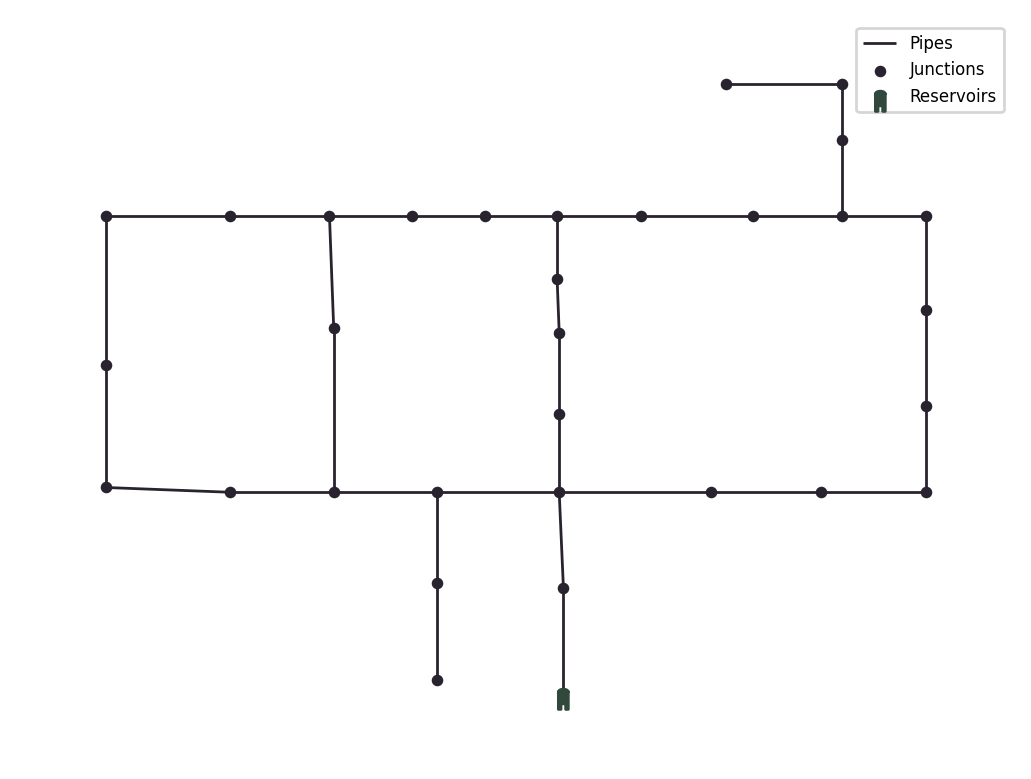

In [11]:
scenario.plot_topology()

In [12]:
topo = scenario.get_topology()
nodes = topo.nodes
edges = topo.edges
print("Nodes: ", nodes, "edges: ", edges)

Nodes:  ['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '1'] edges:  [('2', np.str_('1')), ('2', np.str_('3')), ('3', np.str_('4')), ('3', np.str_('19')), ('3', np.str_('20')), ('4', np.str_('5')), ('5', np.str_('6')), ('6', np.str_('7')), ('7', np.str_('8')), ('8', np.str_('9')), ('9', np.str_('10')), ('10', np.str_('11')), ('10', np.str_('14')), ('11', np.str_('12')), ('12', np.str_('13')), ('14', np.str_('15')), ('15', np.str_('16')), ('16', np.str_('17')), ('16', np.str_('27')), ('17', np.str_('18')), ('18', np.str_('19')), ('20', np.str_('21')), ('20', np.str_('23')), ('21', np.str_('22')), ('23', np.str_('24')), ('23', np.str_('28')), ('24', np.str_('25')), ('25', np.str_('26')), ('25', np.str_('32')), ('26', np.str_('27')), ('28', np.str_('29')), ('29', np.str_('30')), ('30', np.str_('31')), ('31', np.str_('32'))]


### 2. Add Leakages to the Scenario

In this example, we build a scenario with two leakages: A small abrupt leakage and a large incipient leakage in the second week:

In [13]:
leak1 = AbruptLeakage(link_id="6", diameter=0.002,
                      start_time=to_seconds(days=7),
                      end_time=to_seconds(days=8))
scenario.add_leakage(leak1)

leak2 = IncipientLeakage(link_id="19", diameter=0.1,
                         start_time=to_seconds(days=11),
                         end_time=to_seconds(days=13),
                         peak_time=to_seconds(days=12))
scenario.add_leakage(leak2)

Run the complete simulation:

In [14]:
scada_data = scenario.run_simulation(verbose=True)

Running EPANET ...


Time steps: 100%|#########9| 4032/4033 [00:02<00:00, 1950.73it/s]


### 3. Machine Learning based Leakage Detection

Prepare the simulation results for calibrating (i.e. creating) a Machine Learning based leakage detection method:

- Create a feature vector (pressure and flow readings at the sensors).
- Create ground-truth labels utilizing the [`time_points_to_one_hot_encoding()`](https://epyt-flow.readthedocs.io/en/stable/epyt_flow.html#epyt_flow.utils.time_points_to_one_hot_encoding) helper function.

In [15]:
# Concatenate pressure and flow readings into a single feature vector
X = np.concatenate((scada_data.get_data_pressures(), scada_data.get_data_flows()), axis=1)

# Build ground-truth labels -- i.e. indicator of events
events_times = [int(t / params["hydraulic_time_step"])
                for t in scenario.get_events_active_time_points()]
y = time_points_to_one_hot_encoding(events_times, total_length=X.shape[0])

the following three

In [16]:
pressures = scada_data.get_data_pressures()
print(type(pressures))
print(scada_data.get_data_pressures().shape)

<class 'numpy.ndarray'>
(4033, 32)


In [17]:
node_pressures = []
for node in nodes:
    node_pressures.append(pressures[:, int(node) - 1])
node_pressures = np.array(node_pressures)

In [18]:
print("Node pressures shape: ", node_pressures.shape)
print("Node pressures: ", node_pressures)
print("original pressures: ", pressures)

Node pressures shape:  (32, 4033)
Node pressures:  [[54.5454236  54.5454236  54.5454236  ... 50.06574854 50.06574854
  54.13044016]
 [52.79726785 52.79726785 52.79726785 ... 47.78984402 47.78984402
  52.29363627]
 [50.63708659 50.63708659 50.63708659 ... 44.97623206 44.97623206
  50.01250047]
 ...
 [42.66042001 42.66042001 42.66042001 ... 34.59838229 34.59838229
  41.77602723]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [68.84599907 68.84599907 68.84599907 ... 68.51240525 68.51240525
  68.82010512]]
original pressures:  [[68.84599907 54.5454236  52.79726785 ... 42.06106035 42.66042001
   0.        ]
 [68.84599907 54.5454236  52.79726785 ... 42.06106035 42.66042001
   0.        ]
 [68.84599907 54.5454236  52.79726785 ... 42.06106035 42.66042001
   0.        ]
 ...
 [68.51240525 50.06574854 47.78984402 ... 33.88476756 34.59838229
   0.        ]
 [68.51240525 50.06574854 47.78984402 ... 33.88476756 34.59838229
   0.        ]
 [68.82010512 54.13044016 52.29363

Split the data into train and test set -- here, training data is the fault-free first week of the simulation and the second week (containing the leakages) is the test data:

In [19]:
split_point = 2000
X_train, y_train = X[:split_point, :], y[:split_point]
X_test, y_test = X[split_point:, :], y[split_point:]

#### Machine Learning based Event Detector


As a classic baseline, EPyT-Flow already implements a residual-based interpolation detection method called [`SensorInterpolationDetector`](https://epyt-flow.readthedocs.io/en/stable/epyt_flow.models.html#epyt_flow.models.sensor_interpolation_detector.SensorInterpolationDetector).

This method tries to predict the readings of a given sensor based on all other sensors: $f: \vec{x}_t\setminus\{i\} \mapsto (\vec{x}_t)_i$, where $\vec{x}_t$ refers to these sensor ratings at time $t$, and $\vec{x}_t\setminus\{i\}$ denotes these sensor readings without the $i$-th sensor.
An alarm is raised (i.e. event detected) whenever the prediction and the observation of at least one sensor differ significantly:
$$
   \exists i:\; |f(\vec{x}_t\setminus\{i\}) - (\vec{x}_t)_i| > \theta_i
$$
where $\theta_i > 0$ denotes a sensor-specific threshold at which the difference is considered as significant.
For this, the detection method has to be calibrated (i.e. fitted) to a time window of (ideally event-free) sensor readings to determine a suitable threshold $\theta$ that does not raise an alarm when the network is in normal operation (i.e. no events present).

We use this event detector to detect leakages in our generated scenario.
We create and calibrate (i.e. fit) the leakage detector to the first week of simulated data:

In [20]:
detector = SensorInterpolationDetector()
detector.fit(X_train)

Apply the detector to the test data (i.e. second week of simulated data):

In [21]:
suspicious_time_points = detector.apply(X_test)
y_test_pred = time_points_to_one_hot_encoding(suspicious_time_points, X_test.shape[0])

### 4. Evaluation

In order to evaluate the performance of the leakage detector, we could either compute the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) or plot the raised alarms together with the ground truth labels.

Here, we plot event (i.e. leakage) presence over time together with the raised alarms by the detector:

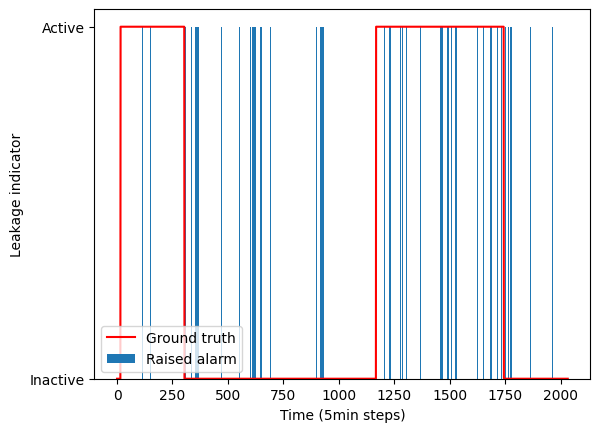

In [22]:
plt.figure()
plt.plot(list(range(len(y_test))), y_test, color="red", label="Ground truth")
plt.bar(list(range(len(y_test_pred))), y_test_pred, label="Raised alarm")
plt.legend()
plt.ylabel("Leakage indicator")
plt.yticks([0, 1], ["Inactive", "Active"])
plt.xlabel("Time (5min steps)")
plt.show()

We observe that the small abrupt leakage is not detected, while the large incipient leakage is detected -- only a single false alarm is raised.

**Note:** More advanced algorithms & methods are likely to show a better detection performance.

### Close the Simulation

Do not forget to close the simulation:

In [23]:
scenario.close()